In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.svm import SVC
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv("./train.csv")
data["label"] = data["label"].astype("int")

Before selecting the right features for predictive model, we are supposed to deal with all missing values in the dataset.

# Split the dataset into training set and test set
Before going to the analysis part, data split should be done at the first place.

training set:test set = 4:1

In [3]:
data_train, data_test = train_test_split(data, test_size = 0.2, random_state=666)

# Identify the percentage of missing values in each feature
Based on training set, we are intending to remove those features with more than 40% NaNs because they will not be able to provide enough information to the modeling

In [4]:
col_ls = dict()
for column_name in data_train.columns:
    col_ls[column_name] = len(data_train[data_train[column_name].isna()])/len(data_train)

for i in sorted(col_ls.items(), key = lambda x: x[1], reverse = True):
    print(f"{i[0]}: {i[1]}")


Capillary refill rate: 0.9824745147325793
Height: 0.8093143415724061
Fraction inspired oxygen: 0.6999022482893451
Glascow coma scale total: 0.4240329562910208
Weight: 0.2708420611646418
pH: 0.17623236978075688
Temperature: 0.020039100684261974
Respiratory rate: 0.012637899734673929
Mean blood pressure: 0.012358609132802682
Diastolic blood pressure: 0.01228878648233487
Heart Rate: 0.01228878648233487
Systolic blood pressure: 0.01228878648233487
Glascow coma scale verbal response: 0.009495880463622399
Glascow coma scale motor response: 0.009426057813154587
Glascow coma scale eye opening: 0.009286412512218964
Oxygen saturation: 0.006842619745845552
Glucose: 0.0008378718056137411
icustay id: 0.0
label: 0.0


## Columns with an acceptable number of NaNs (<40%)
* Weight (continuous)
* pH (continuous)
* Temperature (continuous)
* Respiratory rate (continuous)
* Mean blood pressure (continuous)
* Diastolic blood pressure (continuous)
* Heart Rate (continuous)
* Systolic blood pressure (continuous)
* Glascow coma scale verbal response (categorical)
* Glascow coma scale motor response (categorical)
* Glascow coma scale eye opening (categorical)
* Oxygen saturation (continuous)
* Glucose (continuous)

In [5]:
data_tr_new = data_train[["Weight", "pH", "Temperature", "Respiratory rate", "Mean blood pressure", "Diastolic blood pressure", "Heart Rate", 
                 "Systolic blood pressure", "Glascow coma scale verbal response", "Glascow coma scale motor response", 
                "Glascow coma scale eye opening", "Oxygen saturation", "Glucose", "label"]]
data_te_new = data_test[["Weight", "pH", "Temperature", "Respiratory rate", "Mean blood pressure", "Diastolic blood pressure", "Heart Rate", 
                 "Systolic blood pressure", "Glascow coma scale verbal response", "Glascow coma scale motor response", 
                "Glascow coma scale eye opening", "Oxygen saturation", "Glucose", "label"]]

# Missing values imputation
## Continuous data
Replace the NaNs with medians (calculated from training set) because median is not susceptible to outliers.
## Categorical data
Replace the NaNs with mode (calculated from training set)

In [6]:
# continuous data
feat_con = ["Weight", "pH", "Temperature", "Respiratory rate", "Mean blood pressure", "Diastolic blood pressure", "Heart Rate", "Systolic blood pressure", "Oxygen saturation", "Glucose"]
# training set
data_tr_new.fillna({x: data_tr_new[x].median() for x in feat_con}, inplace = True)
# test set
data_te_new.fillna({x: data_tr_new[x].median() for x in feat_con}, inplace = True)

/home/yucheng/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/home/yucheng/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [7]:
# categorical data
feat_cat = ["Glascow coma scale verbal response", "Glascow coma scale motor response", "Glascow coma scale eye opening"]
# training set
data_tr_new.fillna({x: data_tr_new[x].mode()[0] for x in feat_cat}, inplace = True)
# test set
data_te_new.fillna({x: data_tr_new[x].mode()[0] for x in feat_cat}, inplace = True)

Encode the categorical string data into integer

In [8]:
# encode the categorical string data into integer
def cat_string2int(x, feature_ls):
    
    # the num of categories in training set
    num = len(feature_ls)

    # build up the dict for maping string into int
    str2int_dict = {string:idx for idx, string in enumerate(feature_ls)}

    # if the x is not in the str2int_dict (that will happen in test set)
    if x not in str2int_dict.keys():
        # randomly pick a integer
        res = random.choice(list(str2int_dict.values()))
    else:
        res = str2int_dict[x]

    return res

In [9]:
# encode all the categorical data ["Glascow coma scale verbal response", "Glascow coma scale motor response", "Glascow coma scale eye opening"]
for feat in feat_cat:
    feature_ls = data_tr_new[feat].unique().tolist()
    data_tr_new[feat] = data_tr_new[feat].apply(lambda x: cat_string2int(x, feature_ls))
    data_te_new[feat] = data_te_new[feat].apply(lambda x: cat_string2int(x, feature_ls))
    print(f"feature done! - {feat}")

feature done! - Glascow coma scale verbal response
feature done! - Glascow coma scale motor response
feature done! - Glascow coma scale eye opening


/home/yucheng/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/yucheng/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Select the right features for predictive model
The strategy is to adopt stepwise forward feature selection method:
1. use mutual information to rank the features
2. start from the null model
    1. add each feature from the most important to the least important
    2. check if the changes of model performance are smaller than threshold
        1. if yes, stop adding the feature
        2. if no, continue

In [10]:
ranking_scores = mutual_info_classif(data_tr_new.iloc[:,:-1], data_tr_new.iloc[:, -1], discrete_features='auto', n_neighbors=20, copy=True, random_state=666)

In [11]:
def feature_ranking(ranking_scores):
    feat2score = {idx:i for idx, i in enumerate(ranking_scores)}
    
    feat2score_sorted = {k: v for k, v in sorted(feat2score.items(), key=lambda item: item[1], reverse=True)}
    return feat2score_sorted

In [12]:
ranking_feat = list(feature_ranking(ranking_scores).keys())

In [13]:
auc_roc_ls = []
for i in range(len(ranking_feat)):
    print(f"------------iter {i}------------")
    print(f"features - {ranking_feat[:i+1]}")
    data_tr_used = data_tr_new.iloc[:, ranking_feat[:i+1]]
    

    rf = RandomForestClassifier(random_state = 666)
    parameters = {"max_features": ["auto", "sqrt", "log2"], 'max_depth': [2, 5, 8], 'min_samples_split': [2, 5, 8]}
    
    print("Grid searching")
    clf = GridSearchCV(rf, parameters)

    clf.fit(data_tr_used, data_tr_new['label'])
    y_prob = clf.predict_proba(data_tr_used)[:, 1]
    print(f"Best param: {clf.best_params_}")
    
    auc_roc = roc_auc_score(data_tr_new['label'], y_prob)
    auc_roc_ls.append(auc_roc)

------------iter 0------------
features - [2]
Grid searching
Best param: {'max_depth': 2, 'max_features': 'auto', 'min_samples_split': 2}
------------iter 1------------
features - [2, 9]
Grid searching
Best param: {'max_depth': 2, 'max_features': 'auto', 'min_samples_split': 2}
------------iter 2------------
features - [2, 9, 1]
Grid searching
Best param: {'max_depth': 2, 'max_features': 'auto', 'min_samples_split': 2}
------------iter 3------------
features - [2, 9, 1, 3]
Grid searching
Best param: {'max_depth': 2, 'max_features': 'auto', 'min_samples_split': 2}
------------iter 4------------
features - [2, 9, 1, 3, 7]
Grid searching
Best param: {'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 8}
------------iter 5------------
features - [2, 9, 1, 3, 7, 8]
Grid searching
Best param: {'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 2}
------------iter 6------------
features - [2, 9, 1, 3, 7, 8, 6]
Grid searching
Best param: {'max_depth': 8, 'max_features': 'au

In [14]:
auc_roc_ls

[0.5508040117857335,
 0.6041821211632533,
 0.6363025494879858,
 0.6603994483416653,
 0.7799217112159329,
 0.7912769025829167,
 0.7975178944592269,
 0.8031979049078104,
 0.8128256153241412,
 0.8281162858477128,
 0.8245175299346879,
 0.8379025098438425,
 0.8374919157864322]

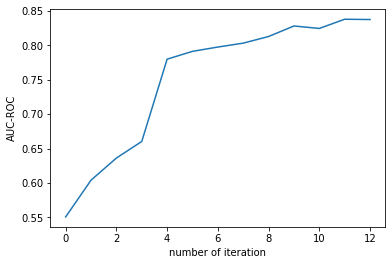

In [15]:
# The changes of AUC-ROC with the feature added one-by-one
plt.figure()
plt.plot([i for i in range(len(auc_roc_ls))], auc_roc_ls)
plt.xlabel("number of iteration")
plt.ylabel("AUC-ROC")
plt.savefig('changes_of_AUCROC.png')
plt.show()

The plot shows that iter 4 with feature [2, 9, 1, 3, 7] should be elbow of the curve.

Features include:

In [16]:
for i in data_tr_new.iloc[:, ranking_feat[:5]].columns.tolist():
    print(i)

Temperature
Glascow coma scale motor response
pH
Respiratory rate
Systolic blood pressure


In [17]:
data_tr4model = data_tr_new.iloc[:, ranking_feat[:5]]
data_te4model = data_te_new.iloc[:, ranking_feat[:5]]
y_tr = data_tr_new['label']
y_te = data_te_new['label']

# Find out the best model with selected features
The selected features: Temperature, Glascow coma scale motor response, pH, Respiratory rate, Systolic blood pressure
## Models to evaluate
### Logistic regression

In [18]:
lr = LogisticRegression(random_state = 666)
parameters = {"C": [0.1, 1, 10], "solver": ["saga", "liblinear", "lbfgs"], "max_iter": [100, 200, 300]}

print("Grid searching")
clf = GridSearchCV(lr, parameters, n_jobs = -1)

clf.fit(data_tr4model, y_tr)
print(f"Best param: {clf.best_params_}")

y_tr_prob = clf.predict_proba(data_tr4model)[:, 1]
y_te_prob = clf.predict_proba(data_te4model)[:, 1]

Grid searching
Best param: {'C': 0.1, 'max_iter': 100, 'solver': 'saga'}


In [19]:
# generate ROC curves with AUC-ROC scores
def generate_eval_info(y_tr_prob, y_tr, y_te_prob, y_te, name):
    auc_roc_tr = roc_auc_score(y_tr, y_tr_prob)
    auc_roc_te = roc_auc_score(y_te, y_te_prob)
    
    fpr_tr, tpr_tr, _ = roc_curve(y_tr, y_tr_prob)
    fpr_te, tpr_te, _ = roc_curve(y_te, y_te_prob)
    
    plt.figure()
    plt.plot(
        fpr_tr,
        tpr_tr,
        color="darkblue",
        label=f"ROC curve - training (area = {auc_roc_tr: 0.3f})",
    )
    plt.plot(
        fpr_te,
        tpr_te,
        color="darkorange",
        label=f"ROC curve - test (area = {auc_roc_te: 0.3f})",
    )
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.savefig(f'{name}.png')
    plt.show()


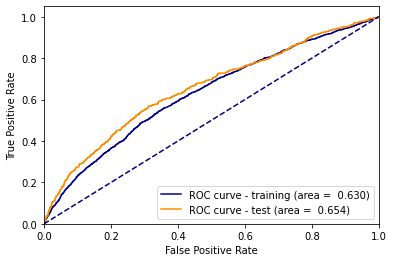

In [20]:
generate_eval_info(y_tr_prob, y_tr, y_te_prob, y_te, "lr")

### Tree-based model
Random forest

In [21]:
rf = RandomForestClassifier(random_state = 666)
parameters = {"max_features": ["auto", "sqrt", "log2"], 'max_depth': [2, 5, 8], 'min_samples_split': [2, 5, 8]}

print("Grid searching")
clf = GridSearchCV(rf, parameters, n_jobs = -1)

clf.fit(data_tr4model, y_tr)
print(f"Best param: {clf.best_params_}")

y_tr_prob = clf.predict_proba(data_tr4model)[:, 1]
y_te_prob = clf.predict_proba(data_te4model)[:, 1]

Grid searching
Best param: {'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 8}


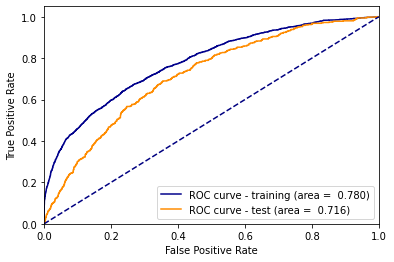

In [22]:
generate_eval_info(y_tr_prob, y_tr, y_te_prob, y_te, "rf")

### Support vector machine

In [27]:
svm = SVC(random_state = 666, probability=True)
parameters = {"C": [0.1, 1, 10], "kernel": ["linear", "poly", "rbf"], "gamma": ["scale", "auto"]}

print("Grid searching")
clf = GridSearchCV(svm, parameters, n_jobs = -1)

clf.fit(data_tr4model, y_tr)
print(f"Best param: {clf.best_params_}")

y_tr_prob = clf.predict_proba(data_tr4model)[:, 1]
y_te_prob = clf.predict_proba(data_te4model)[:, 1]

Grid searching
Best param: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


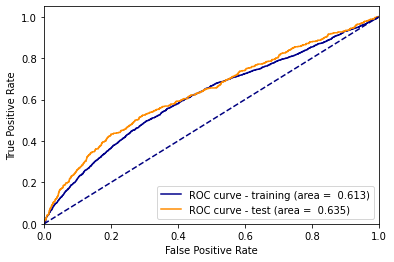

In [28]:
generate_eval_info(y_tr_prob, y_tr, y_te_prob, y_te, "svm")

In [35]:
len(data.columns)

19

In [39]:
data_tr_new.iloc[:, ranking_feat[:5]].columns

Index(['Temperature', 'Glascow coma scale motor response', 'pH',
       'Respiratory rate', 'Systolic blood pressure'],
      dtype='object')